# Dicas diversas sobre Pandas



## Leitura de CSVs fora do padrão


In [1]:
# Importação de Bibliotecas
import pandas as pd
from io import StringIO

# lê CSV de uma string (poderia ser lido do disco como usual)
# este CSV tem vários problemas: linhas desnecessarias no começo, 
# separador diferente, datas no formato brasileiro.

CSV_string = StringIO("""Exemplo de CSV de casos de Covid-19
--------------------------
data;cidade;sintomas;idade
21-04-2021;Curitiba;tosse,febre,dor de garganta;79
22-04-2021;Curitiba;tosse,dor de garganta;39
22-04-2021;Curitiba;tosse;56
23-04-2021;Curitiba;;66
23-04-2021;Curitiba;febre;33
23-04-2021;Curitiba;febre,dor de garganta;77
21-04-2021;Pinhais;coriza,febre,dor de garganta;19
22-04-2021;Pinhais;tosse,dor de garganta;81
22-04-2021;Pinhais;febre,tosse;60
23-04-2021;Pinhais;febre;51
23-04-2021;Pinhais;dor de garganta;17
""")

# Para ler corretamente o CSV especificamos o separador, 
# o número da linha que servirá de cabeçalho, a coluna com datas e seu formato começando pelo dia
df = pd.read_csv(CSV_string, sep=";", header=2, parse_dates=['data'], dayfirst=True)

df.head()

,data,cidade,sintomas,idade
0,2021-04-21,Curitiba,"tosse,febre,dor de garganta",79
1,2021-04-22,Curitiba,"tosse,dor de garganta",39
2,2021-04-22,Curitiba,tosse,56
3,2021-04-23,Curitiba,NaN,66
4,2021-04-23,Curitiba,febre,33


In [2]:
# podemos verificar que os dados foram lidos corretamente
df.dtypes

data        datetime64[ns]
cidade              object
sintomas            object
idade                int64
dtype: object

## Separação de valores de uma coluna com múltiplos itens

A coluna sintomas possui diversos valores separados por vírgula. Se queremos, por exemplo, analisar a proporção de incidência de sintomas, precisamos separar estes valores um por linha.

In [3]:
# O método str.split() no modo expand resolveria este problema se o que esperamos é 
# separar os valores em colunas. No nosso caso, o número e a ordem dos 
# valores varia, portanto o não seria adequado separar em colunas.
df['sintomas'].str.split(',', expand=True)

,0,1,2
0,tosse,febre,dor de garganta
1,tosse,dor de garganta,None
2,tosse,None,None
3,NaN,NaN,NaN
4,febre,None,None
5,febre,dor de garganta,None
6,coriza,febre,dor de garganta
7,tosse,dor de garganta,None
8,febre,tosse,None
9,febre,None,None


In [4]:
# porém, podemos combinar o split com o método explode
# para distribuir os itens em linhas
df['sintomas'].str.split(",").explode()

0               tosse
0               febre
0     dor de garganta
1               tosse
1     dor de garganta
2               tosse
3                 NaN
4               febre
5               febre
5     dor de garganta
6              coriza
6               febre
6     dor de garganta
7               tosse
7     dor de garganta
8               febre
8               tosse
9               febre
10    dor de garganta
Name: sintomas, dtype: object

In [5]:
df_expandida = df.copy()

# transformando os sintomas em listas
df_expandida['sintoma'] = df_expandida['sintomas'].str.split(",")

# usando o explode para repetir os sintomas
# individuais nas linhas
df_expandida = df_expandida.explode('sintoma')

df_expandida

,data,cidade,sintomas,idade,sintoma
0,2021-04-21,Curitiba,"tosse,febre,dor de garganta",79,tosse
0,2021-04-21,Curitiba,"tosse,febre,dor de garganta",79,febre
0,2021-04-21,Curitiba,"tosse,febre,dor de garganta",79,dor de garganta
1,2021-04-22,Curitiba,"tosse,dor de garganta",39,tosse
1,2021-04-22,Curitiba,"tosse,dor de garganta",39,dor de garganta
2,2021-04-22,Curitiba,tosse,56,tosse
3,2021-04-23,Curitiba,NaN,66,NaN
4,2021-04-23,Curitiba,febre,33,febre
5,2021-04-23,Curitiba,"febre,dor de garganta",77,febre
5,2021-04-23,Curitiba,"febre,dor de garganta",77,dor de garganta


<AxesSubplot:ylabel='sintoma'>

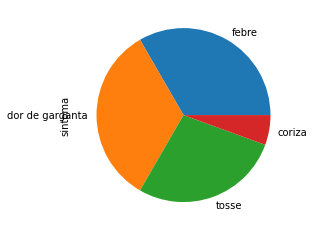

In [6]:
# Agora, com os sintomas separados, podemos
# calcular a frequência
df_expandida['sintoma'].value_counts().plot.pie()

## Criando grupos de faixas etárias

Outra tarefa comum no tratamento de dados é dividir os valores de uma coluna em categorias de acordo com faixas. No exemplo abaixo dividimos as idades em faixas etárias.

In [7]:
faixas= [0,12,20,65,110]
labels = ['Criança','Adolescente','Adulto','Idoso']
df['Faixa Etária'] = pd.cut(df['idade'], bins=faixas, labels=labels, right=False)

df

,data,cidade,sintomas,idade,Faixa Etária
0,2021-04-21,Curitiba,"tosse,febre,dor de garganta",79,Idoso
1,2021-04-22,Curitiba,"tosse,dor de garganta",39,Adulto
2,2021-04-22,Curitiba,tosse,56,Adulto
3,2021-04-23,Curitiba,NaN,66,Idoso
4,2021-04-23,Curitiba,febre,33,Adulto
5,2021-04-23,Curitiba,"febre,dor de garganta",77,Idoso
6,2021-04-21,Pinhais,"coriza,febre,dor de garganta",19,Adolescente
7,2021-04-22,Pinhais,"tosse,dor de garganta",81,Idoso
8,2021-04-22,Pinhais,"febre,tosse",60,Adulto
9,2021-04-23,Pinhais,febre,51,Adulto
